In [1]:
!pip install fake_useragent
from bs4 import BeautifulSoup
from bs4.element import Tag
import requests
import time
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [4]:
# скачиваю данные в DataFrame из файла
df_raw = pd.read_csv('parsing data.csv')
df_raw.drop(columns = ['Unnamed: 0'], inplace = True)
df_raw.head(2)

,Личность подтверждена,Статус,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,Формат обучения,Образование,Предмет,Цена,С отличием
0,False,Частный преподаватель,7,6.0,107.0,5.00,51.0,Дистанционно,МГУ им. М.В. Ломоносова,Русский язык,2112.5,False
1,True,Школьный преподаватель,38,6.0,139.0,4.89,41.0,Дистанционно,Волгоградский государственный педагогический ...,Русский язык,1000.0,False


Заполненяем пропуски:
1. Наны в признаках: `На сайте, Заказы в работе, количество отзывов` заполняем нулями
2. Оценку для преподавателей, у которой ее нет по каким-то причинам, заполняем средним значением
3. Для преподавателей, не указавших статус или формат обучения выбираем наиболее часто встречавшееся значение среди других тьюторов.
4. Пару анкет было без цены - мы их удалили

In [5]:
# Заполнение пропусков в столбце 'на сайте' значением 0
df_raw['На сайте'] = df_raw['На сайте'].fillna(0)

# Заполнение пропусков в столбце 'Заказы в работе' значением 0
df_raw['Заказы в работе'] = df_raw['Заказы в работе'].fillna(0)

# Заполнение пропусков в столбце 'Количество отзывов' значением 0
df_raw['Количество отзывов'] = df_raw['Количество отзывов'].fillna(0)

# Заполнение пропусков в столбце 'Оценка' средним значением
mean_mark = df_raw['Оценка'].astype(float).mean()
df_raw['Оценка'] = df_raw['Оценка'].fillna(mean_mark)

# Заполнение пропусков в столбце 'Статус' самым популярным значением
most_common_stat = df_raw['Статус'].mode()
df_raw['Статус'] = df_raw['Статус'].fillna(most_common_stat)

# Заполнение пропусков в столбце 'Формат обучения' самым популярным значением
most_common_format = df_raw['Формат обучения'].mode()
df_raw['Формат обучения'] = df_raw['Формат обучения'].fillna(most_common_format)

# удаляем анкету без цены
df_raw = df_raw[df_raw['Цена'].notna()]

In [9]:
df_raw.isna().sum()

Личность подтверждена     0
Статус                    0
Стаж                      0
На сайте                  0
Заказы в работе           0
Оценка                    0
Количество отзывов        0
Формат обучения           0
Образование              19
Предмет                   0
Цена                      0
С отличием                0
dtype: int64

Это нормально, что в образовании есть немного нанов, далее мы удалим этот признак, остатив другие характеристики, полученные на основе информации о вузе (признаки "топ-10" и "топ-20" вуз).

Начнем как раз с ВУЗа - OHE для текущих данных лучше не делать, поэтому создадим списки из топ-10 и топ-20 вузов и добавим соответсвтующий признак (1 - если входит, 0 - если не входит)

In [11]:
# проверяем, заканчивал ли преподаватель вуз из Топ-10 или Топ-20 вуз
top_ten = ['Национальный исследовательский Томский политехнический университет', 'МГУ им. М. В. Ломоносова', 'ФГАОУ ВО НИ ТПУ', 'ТПУ', 'Томский политехнический университет', 'Московский физико-технический институт (МФТИ)', 'Московский физико-технический институт (национальный исследовательский университет)', 'МФТИ (национальный исследовательский университет)', 'Национальный исследовательский университет "Московский физико-технический институт"', 'НИУ МФТИ', 'МФТИ', 'Московский физико-технический институт', 'Московский физико-технический институт (МФТИ)', 'Национальный исследовательский университет Московский физико-технический институт', 'НИУ Московский физико-технический институт', 'Московский Государственный Университет им. М.В.Ломоносова', 'МГУ им. М.В. Ломоносова', 'Московский государственный университет имени М.В. Ломоносова', 'МГУ', 'МГУ имени М.В.Ломоносова', 'МГУ имени М.В. Ломоносова', 'Московский Государственный Университет им. М.В. Ломоносова', 'Московский государственный университет имени М.В.Ломоносова', 'Санкт-Петербургский государственный университет', 'СПбГУ', 'Санкт-Петербургский университет', 'СПбУ', 'Национальный исследовательский ядерный университет «МИФИ»', 'НИЯУ МИФИ', 'МИФИ', 'Национальный исследовательский ядерный университет Московский инженерно-физический институт', 'НИЯУ Московский инженерно-физический институт', 'Московский инженерно-физический институт', 'Московский государственный технический университет имени Н.Э. Баумана', 'Московский государственный технический университет им. Н.Э. Баумана', 'Московский государственный технический университет имени Н.Э.Баумана', 'Московский государственный технический университет им. Н.Э.Баумана' , 'МГТУ им. Н.Э. Баумана', 'МГТУ им. Н.Э.Баумана', 'МГТУ имени Н.Э. Баумана', 'МГТУ имени Н.Э.Баумана', 'МГТУ', 'Национальный исследовательский университет "Высшая школа экономики"', 'НИУ ВШЭ', 'Высшая школа экономики', 'Национальный исследовательский университет ВШЭ', 'Национальный исследовательский университет «Высшая школа экономики» (НИУ ВШЭ)', 'НИУ Высшая школа экономики', 'ВШЭ', 'Московский Государственный Институт Международных Отношений', 'МГИМО', 'МГИМО МИД России', 'Московский государственный институт международных отношений МИД Российской Федерации', 'Московский государственный институт международных отношений МИД РФ', 'Московский государственный институт международных отношений МИД России', 'МГИМО МИД Российской Федерации', 'МГИМО МИД РФ', 'Санкт-Петербургский политехнический университет Петра Великого', 'ФГАОУ ВО СПбПУ', 'СПбПУ', 'ФГАОУ ВО «СПбПУ»', 'Политех', 'Санкт-Петербургский политехнический университет Петра Великого', 'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина', 'Уральский федеральный университет им. первого Президента России Б.Н. Ельцина', 'Уральский федеральный университет имени первого Президента России Б.Н.Ельцина', 'Уральский федеральный университет им. первого Президента России Б.Н.Ельцина', 'Уральский федеральный университет имени Б.Н. Ельцина', 'Уральский федеральный университет им. Б.Н.Ельцина', 'ФГАОУ ВО «УрФУ имени первого Президента России Б.Н. Ельцина»', 'Уральский федеральный университет', 'УрФУ', 'МФТИ, Московский Физико-Технический Институт (государственный исследовательский университет)', 'НИЯУ МИФИ', 'Ленинградский государственный университет (СПбГУ)', 'Национальный исследовательский университет «Высшая школа экономики»', 'УРФУ', 'Московский Государственный Университет имени М. В. Ломоносова', 'МГУ им. М.В. Ломоносова', 'МГУ им.М.В.Ломоносова', 'МГУ имени Ломоносова']
df_raw['Топ-10 вуз'] = df_raw['Образование'].isin (top_ten).astype(int)
top_twenty = ['Национальный исследовательский технологический университет "МИСИС"', 'Новосибирский национальный исследовательский государственный университет', 'НГУ', 'Новосибирский государственный университет', 'Финансовый университет при Правительстве РФ', 'Финансовый университет при Правительстве', 'Финансовый университет', 'Финансовый университет при Правительстве России', 'Финансовый университет при Правительстве Российской Федерации', 'Российская академия народного хозяйства и государственной службы при Президенте РФ', 'Российская академия народного хозяйства и государственной службы при Президенте', 'Российская академия народного хозяйства и государственной службы при Президенте России', 'Российская академия народного хозяйства и государственной службы при Президенте Российской Федерации', 'РАНХиГС', 'РАНХИГС', 'Санкт-Петербургский национальный исследовательский университет информационных технологий, механики и оптики', 'Национальный исследовательский университет ИТМО', 'НИУ ИТМО', 'НИУ информационных технологий, механики и оптики', 'Плехановский университет', 'Российский экономический университет имени Г.В. Плеханова', 'Российский экономический университет им. Г.В. Плеханова', 'Российский экономический университет имени Г.В.Плеханова', 'Российский экономический университет им. Г.В.Плеханова', 'РЭУ имени Г.В. Плеханова', 'РЭУ им. Г.В. Плеханова', 'Первый Московский государственный медицинский университет имени И.М. Сеченова Минздрава России', 'Первый Московский государственный медицинский университет имени И.М. Сеченова', 'Первый Московский государственный медицинский университет имени И.М. Сеченова Минздрава РФ', 'Первый Московский государственный медицинский университет им. И.М. Сеченова Минздрава России', 'Первый Московский государственный медицинский университет им. И.М. Сеченова', 'Первый Московский государственный медицинский университет им. И.М. Сеченова Минздрава РФ', 'Первый МГМУ им. И. М. Сеченова', 'Первый МГМУ им. И.М. Сеченова Минздрава России', 'МГМУ им. И.М. Сеченова Минздрава России', 'МГМУ им. И. М. Сеченова', 'ФГАОУ ВО Первый МГМУ им. И.М. Сеченова Минздрава России (Сеченовский Университет)', 'ФГАОУ ВО Первый МГМУ им. И.М. Сеченова Минздрава России', 'Сеченовский Университет', 'Университет науки и технологий МИСИС', 'Университет науки и технологий «МИСиС»', 'Национальный исследовательский технологический университет «МИСиС»', 'МИСиС', 'МИСИС', 'НИТУ МИСиС', 'НИТУ «МИСиС»', 'Национальный исследовательский Томский государственный университет', 'ТГУ', 'Томский государственный университет', 'НИ ТГУ', 'Российский университет дружбы народов', 'Российский университет дружбы народов (РУДН)', 'Российский университет дружбы народов имени Патриса Лумумбы', 'Российский университет дружбы народов им. Патриса Лумумбы', 'РУДН', 'Казанский (Приволжский) федеральный университет', 'ФФГАОУВО КФУ', 'ФФГАОУВО "КФУ"', 'КФУ', 'Казанский федеральный университет', 'Приволжский федеральный университет', 'Казанский университет']
df_raw['Топ-20 вуз'] = df_raw['Образование'].isin (top_twenty).astype(int)
df_raw.drop(columns='Образование', inplace=True)

Text(0.5, 1.0, 'Ящик с усами для цены в зависимости от топ-10 вузов')

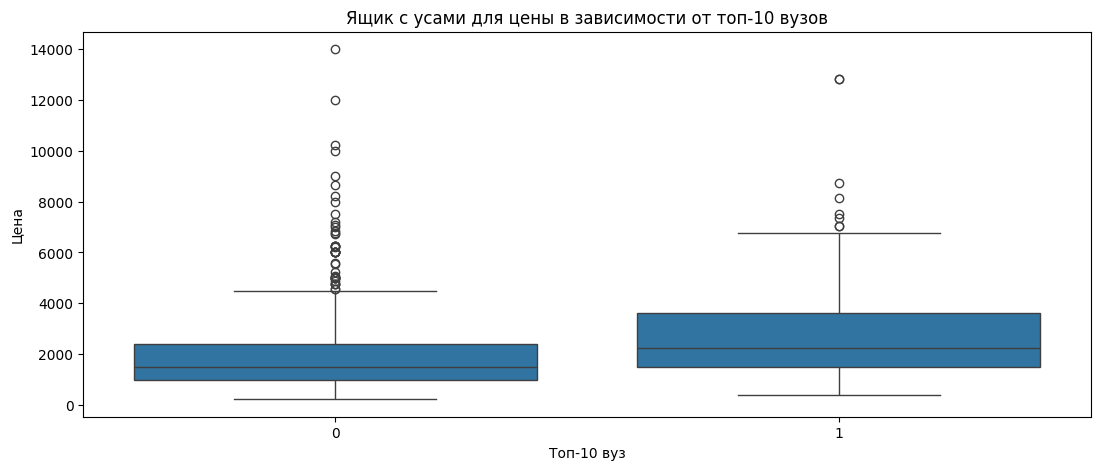

In [14]:
plt.figure(figsize=(13,5))
sns.boxplot(x='Топ-10 вуз',y='Цена',data = df_raw)
plt.title('Ящик с усами для цены в зависимости от топ-10 вузов')

Text(0.5, 1.0, 'Ящик с усами для цены в зависимости от топ-10 вузов')

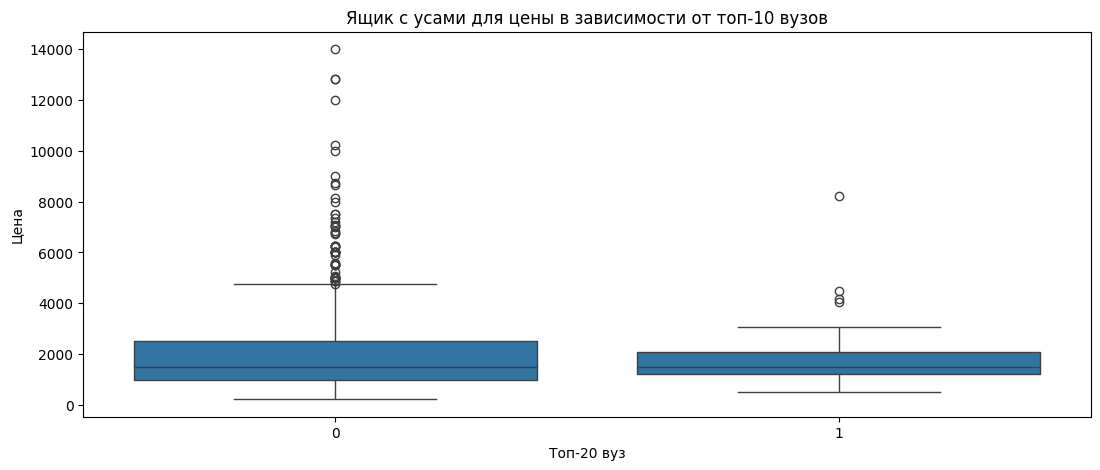

In [15]:
plt.figure(figsize=(13,5))
sns.boxplot(x='Топ-20 вуз',y='Цена',data = df_raw)
plt.title('Ящик с усами для цены в зависимости от топ-20 вузов')

Действительно видно, что цены на репетиторов из топ-10 вузов выше, чем на репетиторов не из этой десятки, то есть добавление этого признака оправдано и может оказаться полезным. У топ-20 различие уже не такое сильное, то есть имеет смысл отказаться от этого признака.

In [79]:
df_raw.drop('Топ-20 вуз', axis=1, inplace=True)
# ошибка потому что я удалила уже, а потом случайно еще раз нажала удалить, а уже нечего удалять

KeyError: "['Топ-20 вуз'] not found in axis"

Стоит также предположить, что цена сильно зависит и от предмета. Визуализируем это, чтобы рассмотреть подробнее:

<Axes: xlabel='Предмет', ylabel='Цена'>

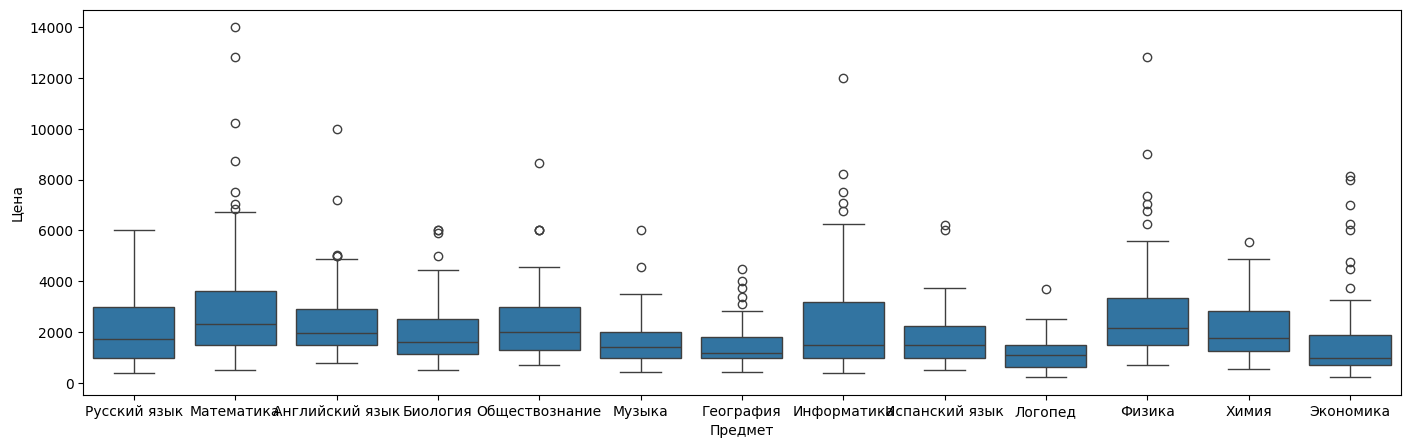

In [17]:
plt.figure(figsize=(17,5))
sns.boxplot(x='Предмет',y='Цена',data = df_raw)

Попробуем добавить три признака для разбивки предметов:

1) разделим на преметы ЕГЭ и нет

2) разделим на три группы - гуманитарные, естестенные и технические

3) разделим на "языковые" предметы и неязыковые

In [45]:
# проверяем входит ли предмет в перечень ЕГЭ
rse_lst = ['Русский язык', 'Математика', 'Английский язык','Биология', 'Обществознание', 'География', 'Информатика', 'Физика', 'Химия', 'Испанский язык']
df_raw['Предмет ЕГЭ'] = df_raw['Предмет'].isin (rse_lst).astype(int)


# делим и распределяем предметы на гуманитарные, естественные и технические
gumant = ['Русский язык', 'Английский язык', 'Обществознание', 'Испанский язык']
estestv = ['Биология', 'Физика', 'Химия', 'География']
tehnich = ['Математика', 'Информатика', 'Экономика']
df_raw['Гуманитарная наука'] = df_raw['Предмет'].isin (gumant).astype(int)
df_raw['Естественная наука'] = df_raw['Предмет'].isin (estestv).astype(int)
df_raw['Техническая наука'] = df_raw['Предмет'].isin (tehnich).astype(int)

# проверяем является ли предмет языком
lang_lst = ['Русский язык', 'Английский язык', 'Испанский язык']
df_raw['Языковой предмет'] = df_raw['Предмет'].isin (lang_lst).astype(int)

1. Давайте точнее поразбираемся - влияет ли, является ли предмет достпуным для сдачи ЕГЭ на цену, и поищем другие интересные вещи.

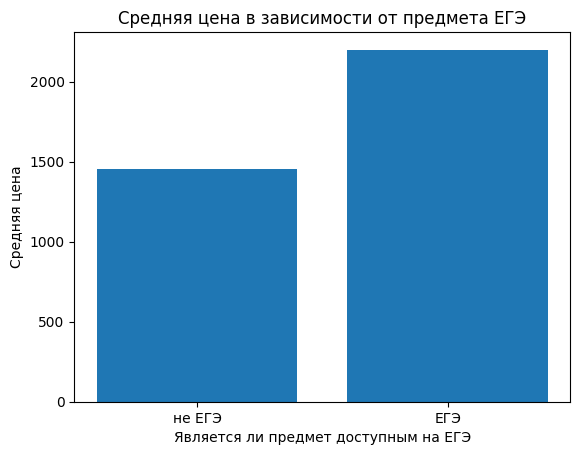

In [25]:
# Группируем данные по предмету ЕГЭ и считаем среднюю цену
mean_price = df_raw.groupby('Предмет ЕГЭ')['Цена'].mean()

plt.bar(mean_price.index, mean_price.values)
plt.xticks(mean_price.index, ['не ЕГЭ', 'ЕГЭ'])
plt.xlabel('Является ли предмет доступным на ЕГЭ')
plt.ylabel('Средняя цена')
plt.title('Средняя цена в зависимости от предмета ЕГЭ')
plt.show()

In [23]:
df_raw[df_raw['Предмет ЕГЭ'] == 1].describe()

,На сайте,Заказы в работе,Оценка,Количество отзывов,Цена,Топ-10 вуз,Топ-20 вуз,Предмет ЕГЭ,Гуманитарная наука,Естественная наука,Техническая наука
count,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000,894.0,894.000000,894.000000,894.000000
mean,2.461689,12.630872,4.962993,3.992170,2200.438935,0.149888,0.038031,1.0,0.400447,0.398210,0.201342
std,1.861987,24.010967,0.103595,7.985215,1598.642796,0.357162,0.191379,0.0,0.490263,0.489803,0.401228
min,0.000000,0.000000,3.500000,0.000000,375.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,1.000000,0.000000,4.951735,0.000000,1125.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
50%,2.000000,3.000000,4.951735,1.000000,1740.196078,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
75%,4.000000,14.000000,5.000000,4.000000,2812.500000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000
max,7.000000,226.000000,5.000000,79.000000,14000.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [26]:
df_raw[df_raw['Предмет ЕГЭ'] == 0].describe()

,На сайте,Заказы в работе,Оценка,Количество отзывов,Цена,Топ-10 вуз,Топ-20 вуз,Предмет ЕГЭ,Гуманитарная наука,Естественная наука,Техническая наука
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.0,269.0,269.0,269.000000
mean,1.951673,0.754647,4.914140,0.308550,1456.418390,0.055762,0.029740,0.0,0.0,0.0,0.334572
std,1.960929,2.672278,0.275976,1.507927,1144.443419,0.229889,0.170185,0.0,0.0,0.0,0.472720
min,0.000000,0.000000,1.000000,0.000000,225.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,0.166667,0.000000,4.951735,0.000000,800.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,1.000000,0.000000,4.951735,0.000000,1125.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
75%,3.000000,0.000000,4.951735,0.000000,1721.428571,0.000000,0.000000,0.0,0.0,0.0,1.000000
max,7.000000,25.000000,5.000000,19.000000,8125.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000


Итог - по всем меркам цена и другим показатели для репетиторов по предметам ЕГЭ выше - так что точно имеет смысл добавлять этот признак

2. Теперь поработаем с делением предметов на гуманитарные, естественные и технические - будет ли тип предмета влиять на цену и есть ли еще инетресные закономерности, связанные с этим делением

In [57]:
df_raw[df_raw['Техническая наука'] == 1]['Цена'].mean()

2338.252880658436

In [58]:
df_raw[df_raw['Гуманитарная наука'] == 1]['Цена'].mean()

2105.1382320941552

In [59]:
df_raw[df_raw['Естественная наука'] == 1]['Цена'].mean()

2053.993612894596

In [70]:
df_raw[(df_raw['Естественная наука'] != 1) & (df_raw['Гуманитарная наука'] != 1) & (df_raw['Естественная наука'] != 1)]['Цена'].mean()

1946.7878426943016

In [71]:
df_sub_split = pd.DataFrame({'Предмет': ['Техническая наука', 'Гуманитарная наука', 'Естественная наука', 'Прочие'], 'Средняя цена': [2338.3, 2105.1, 2054.0, 1946.8]})
df_sub_split

,Предмет,Средняя цена
0,Техническая наука,2338.3
1,Гуманитарная наука,2105.1
2,Естественная наука,2054.0
3,Прочие,1946.8


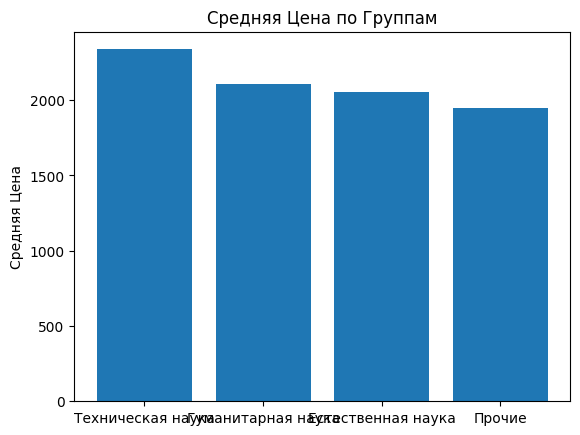

In [72]:
plt.bar(df_sub_split['Предмет'], df_sub_split['Средняя цена'])
plt.ylabel('Средняя Цена')
plt.title('Средняя Цена по Группам')
plt.show()

Все 4 столбца имеют разные средние цены, поэотму целесообразно выделить три из них и добавить соотвествубщие признаки.

3. Рассмотрим, что нам дает информация о том, является ли предмет языком или нет.

Text(0.5, 1.0, 'Ящик с усами для цены в зависимости от того, является ли предмет языком или нет')

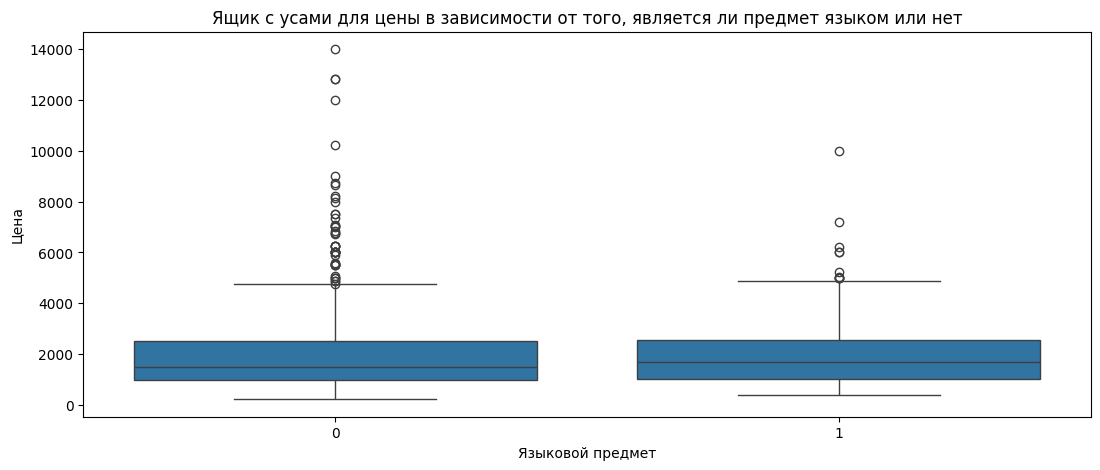

In [77]:
plt.figure(figsize=(13,5))
sns.boxplot(x='Языковой предмет',y='Цена',data = df_raw)
plt.title('Ящик с усами для цены в зависимости от того, является ли предмет языком или нет')

Особо ничего не показывает, значения показателей для предметов-языков и не-языков примерно совпадают. Можно удалять признак за ненадобностью.

In [81]:
df_raw.drop('Языковой предмет', axis=1, inplace=True)

<ipython-input-81-f422bfe19dd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw.drop('Языковой предмет', axis=1, inplace=True)


Еще в первичных данных у нас есть сведения об оценке (рейтинге преподавателя) - посмотрим, что могут принести они.

<Axes: xlabel='Оценка', ylabel='Цена'>

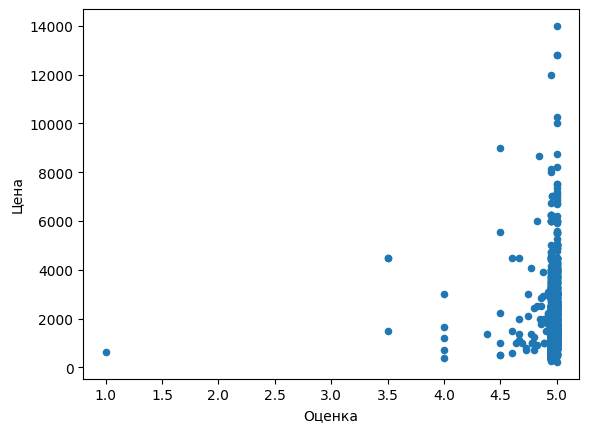

In [30]:
df_raw.plot.scatter(x = 'Оценка', y = 'Цена')

Давайте посмотрим на график без этого выброса с оценкой = 1

In [ ]:
df_raw_filter = df_raw[df_raw['Оценка'] != 1]
df_raw_filter

<Axes: xlabel='Оценка', ylabel='Цена'>

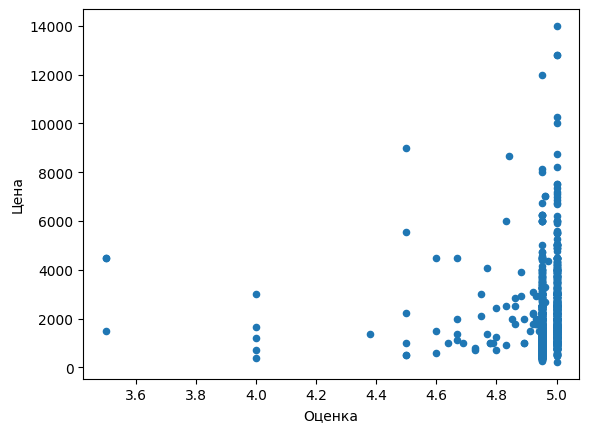

In [33]:
df_raw_filter.plot.scatter(x = 'Оценка', y = 'Цена')

In [43]:
df_raw_filter[df_raw_filter['Оценка'] <= 4.7]['Цена'].mean()

2298.3630952380954

In [44]:
df_raw_filter[df_raw_filter['Оценка'] > 4.7]['Цена'].mean()

2023.8648860845437

Интересно, что у репетиторов, у которых меньше оценка (рейтинг), цена выше. Объяснений почему так можно придумать несколько, но в приницпе было не очевидно.

И последнее с чем мы поработаем - с данными о стаже. Выберем 15% преподавателей с самым большим стажем и посмотрим на распределения для них

In [74]:
# ищем 0,85 квантиль стажа и добавляем признак, показывающий, что стаж препода больше этого значения
df_raw = df_raw[(df_raw['Стаж'] != 'Студент') & (df_raw['Стаж'] != 'Частный')]
df_raw['Стаж'] = df_raw['Стаж'].astype(float)
biggest_experience = df_raw['Стаж'].quantile(0.85)
df_raw['Большой стаж'] = (df_raw['Стаж'].astype(float) > biggest_experience).astype(int)

<ipython-input-74-e7ee14de9e0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Стаж'] = df_raw['Стаж'].astype(float)
<ipython-input-74-e7ee14de9e0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Большой стаж'] = (df_raw['Стаж'].astype(float) > biggest_experience).astype(int)


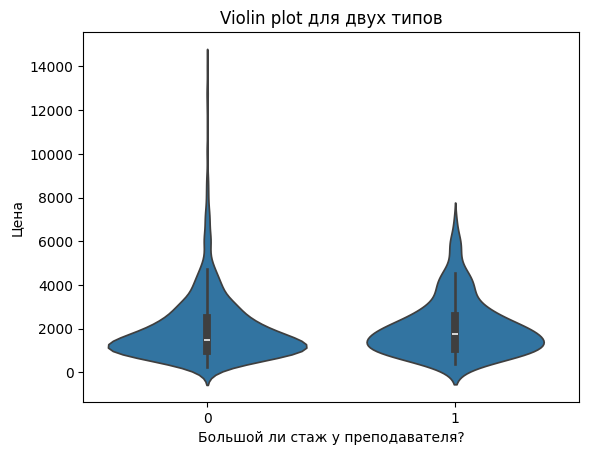

In [76]:
sns.violinplot(x='Большой стаж', y='Цена', data=df_raw)
plt.xlabel('Большой ли стаж у преподавателя?')
plt.ylabel('Цена')
plt.title('Violin plot для двух типов')
plt.show()

Интересно, что преподаватели с большим стажем не особо поднимают цену - первый и третий квантиль, медиана, минимум, самые "частые" цены - примерно одинаковые. А еще интересно, что именно преподаватели с не таким большим опытом работают за самый большой ценник (возможно, более возрастные и опытные учителя просто имеют психологический барьер на устоновление высокой цены, но это просто догадка, которую не проверить тут).

In [84]:
# ванхотим
df = pd.get_dummies(df_raw)
df = df.astype(float)

Снова добавляем вторичные признаки, в этот раз - квадраты и полиномы, чтобы модель отыскала в том числе нелинейные взаимосвязи. Взяты квадраты всех числовых признаков `'Стаж', 'На сайте', 'Заказы в работе', 'Оценка', 'Количество отзывов'`, далее полиномы первой степени этих признаков формата `Признак_1 * Признак_2` и полиномы второй степени формата `Признак_1^2 * Признак_2`

In [85]:
columns_to_create_new_features = df.columns[1:6]
#создание квадратов признаков
for i in range(len(columns_to_create_new_features.values)):
  df[f'{columns_to_create_new_features[i]}^2'] = df[columns_to_create_new_features[i]]**2
#полиномы первой степени
for i in range(len(columns_to_create_new_features.values[:-1])):
  for j in range(len(columns_to_create_new_features.values[i+1:])):
    df[f'{columns_to_create_new_features[i]} * {columns_to_create_new_features[i+1:][j]}'] = df[columns_to_create_new_features[i]] * df[columns_to_create_new_features[i+1:][j]]
#полиномы, где один признак - квадрат, а другой - нет
for i in range(len(columns_to_create_new_features.values)):
  for j in range(len(columns_to_create_new_features.values)):
    if i==j:
      continue
    df[f'{columns_to_create_new_features[i]}^2 * {columns_to_create_new_features[j]}'] = df[columns_to_create_new_features[i]]**2 * df[columns_to_create_new_features[j]]


Проводим нормализацию признаков минимаксом. Почему именно так? One-hot закодированные категориальные признаки принимают значения от 0 до 1, поэтому применим мин-макс нормализацию и к численным признакам. Благодаря единообразию значений признаков, коэффициенты будут хорошо интерпретируемы

In [86]:
# мин-макс нормализация всего кроме таргета
target = df['Цена']
df.drop(columns = 'Цена', inplace = True)
df = (df-df.min ())/(df.max ()-df.min ())
df['Цена'] = target
df

,Личность подтверждена,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,С отличием,Топ-10 вуз,Предмет ЕГЭ,Гуманитарная наука,...,Заказы в работе^2 * Количество отзывов,Оценка^2 * Стаж,Оценка^2 * На сайте,Оценка^2 * Заказы в работе,Оценка^2 * Количество отзывов,Количество отзывов^2 * Стаж,Количество отзывов^2 * На сайте,Количество отзывов^2 * Заказы в работе,Количество отзывов^2 * Оценка,Цена
0,0.0,0.098361,0.857143,0.473451,1.000000,0.645570,0.0,1.0,1.0,1.0,...,0.186640,0.102720,0.857143,0.485022,0.645570,0.114683,0.416760,0.224087,0.416760,2112.500
1,1.0,0.606557,0.857143,0.615044,0.972500,0.518987,0.0,0.0,1.0,1.0,...,0.253210,0.592081,0.819843,0.602657,0.496403,0.402356,0.269348,0.188137,0.263422,1000.000
2,1.0,0.180328,0.714286,0.371681,1.000000,0.455696,0.0,0.0,1.0,1.0,...,0.081195,0.186097,0.714286,0.380765,0.455696,0.097959,0.173049,0.087655,0.207659,4187.500
3,1.0,0.344262,0.714286,0.190265,1.000000,0.367089,0.0,0.0,1.0,1.0,...,0.017140,0.352850,0.714286,0.194915,0.367089,0.116541,0.112295,0.029118,0.134754,1650.000
4,1.0,0.065574,0.571429,0.115044,0.970000,0.215190,0.0,0.0,1.0,1.0,...,0.003673,0.065415,0.544329,0.112267,0.204985,0.009102,0.030871,0.006050,0.045195,3921.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,0.0,0.426230,0.000000,0.000000,0.987934,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.427577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,375.000
1164,0.0,0.081967,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.086045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000
1165,0.0,0.163934,0.000000,0.000000,0.987934,0.000000,0.0,1.0,0.0,0.0,...,0.000000,0.165897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2500.000
1166,0.0,0.180328,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.186097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000


На этом добавление признаков и обработка закончена, переходим к гипотезам.

In [88]:
df.to_csv('df.csv', encoding='utf-8')